In [1]:
push!(LOAD_PATH, "./")
using Plots
using Bspline
using FastGaussQuadrature
using LinearAlgebra
using WriteVTK

┌ Info: Precompiling Bspline [top-level]
└ @ Base loading.jl:1278


In [2]:
# 被積分関数f，区間[a,b]，積分点の個数nipを引数にとり，積分値を返す
function INT2(f,a,b,nip)
    I = 0
    nodes,weights = gausslegendre(nip)
    for i in 1:nip
        I += f((b-a)/2*nodes[i]+(a+b)/2)*weights[i]
    end
    I *= (b-a)/2
    return I
end

INT2 (generic function with 1 method)

In [3]:
# B-spline基底関数を表示する
function plotBs(p,k)
    N = length(k)-p-1
    tl = 256
    t = collect(range(1.0e-10, stop=1.0-1.0e-10, length=tl))

    v = zeros(Float64, (N, tl))    # 評価値v[基底関数の番号][評価点の番号]
    for i=1:N
        for j=1:tl
            v[i,j] = Bs(i,p,k,t[j])
        end
    end
    plot(t,v')
end

plotBs (generic function with 1 method)

In [4]:
# 弾性体の形状をNURBSで表現する

# 初期の基底関数
p1i = 1
p2i = 1
k1i = [0.0, 0.0, 0.5, 1.0, 1.0]
k2i = [0.0, 0.0, 1.0, 1.0]
N1i = length(k1i)-p1i-1
N2i = length(k2i)-p2i-1
Ni = N1i*N2i # 基底関数の組み合わせの総数(制御点の数に合わせる)

# 初期の制御点
Ai = zeros(Float64,2,Ni) # A[次元,α]
Ai[1,:] = [0.0, 0.0, 9.0, 10.0, 9.0, 10.0]
Ai[2,:] = [0.0, 1.0, 0.0, 1.0, -2.0, -2.0]

# 初期のNURBS基底関数
Ri(α1i,α2i,t1,t2) = Bs(α1i,p1i,k1i,t1)*Bs(α2i,p2i,k2i,t2)

# 形状表現（(t1,t2)と(x1,x2)の対応関係を作る(パラメータ空間から物理空間への写像を作る)）
t1l = 100
t2l = 100
t3l = 1
t1 = collect(range(1.0e-10,1.0-1.0e-10,length=t1l))
t2 = collect(range(1.0e-10,1.0-1.0e-10,length=t2l))
x = zeros(Float64,(3,t1l,t2l,t3l)) # x[次元,1軸方向の評価点,2軸方向の評価点]
for d in 1:2
    for i in 1:t1l
        for j in 1:t2l
            for αi in 1:Ni # 基底関数の通し番号
                α1i = div(αi-1,N2i)+1 # 1軸方向の基底関数の番号
                α2i = (αi-1)%N2i+1 # 2軸方向の基底関数の番号
                
                x[d,i,j] += Ri(α1i,α2i,t1[i],t2[j])*Ai[d,αi]
            end
        end
    end
end

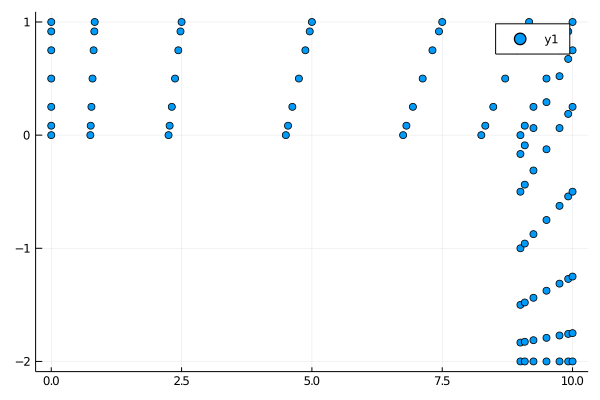

In [5]:
# リファインメント

# リファインメント後の基底関数
p1 = 4
p2 = 2
k1 = [0.0, 0.0, 0.0, 0.0, 0.0, 1/6, 2/6, 3/6, 3/6, 3/6, 3/6, 4/6, 5/6, 1.0, 1.0, 1.0, 1.0, 1.0]
k2 = [0.0, 0.0, 0.0, 1/6, 2/6, 4/6, 5/6, 1.0, 1.0, 1.0]
N1 = length(k1)-p1-1
N2 = length(k2)-p2-1
N = N1*N2

# Cijを求める
C1 = zeros(Float64,(N1,N1i))
C2 = zeros(Float64,(N2,N2i))

κ1 = [k1[j]*(N1-j)/(N1+1)+k1[j+p1+1]*(j+1)/(N1+1) for j in 1:N1]
κ2 = [k2[j]*(N2-j)/(N2+1)+k2[j+p2+1]*(j+1)/(N2+1) for j in 1:N2]

B1i = [Bs(j,p1i,k1i,κ1[i]) for i in 1:N1, j in 1:N1i]
B2i = [Bs(j,p2i,k2i,κ2[i]) for i in 1:N2, j in 1:N2i]
B1 = [Bs(j,p1,k1,κ1[i]) for i in 1:N1, j in 1:N1]
B2 = [Bs(j,p2,k2,κ2[i]) for i in 1:N2, j in 1:N2]

C1 = inv(B1)*B1i
C2 = inv(B2)*B2i

# リファインメント後の制御点を求める
A = zeros(Float64,(2,N))
for α in 1:N
    α1 = div(α-1,N2)+1
    α2 = (α-1)%N2+1
    for αi in 1:Ni
        α1i = div(αi-1,N2i)+1
        α2i = (αi-1)%N2i+1
        
        A[1,α] += C1[α1,α1i]*C2[α2,α2i]*Ai[1,αi]
        A[2,α] += C1[α1,α1i]*C2[α2,α2i]*Ai[2,αi]
    end
end

plot(A[1,:],A[2,:], seriestype=:scatter)

In [6]:
# 剛性行列を作成する準備

# ラメ定数
λ = 122.0e3
μ = 79.0e3

# 基底関数の台を返す関数 i:基底関数の番号
function supp(i,p,k) 
    return [k[j] for j in i:i+p+1]
end

# NURBS基底関数 α:基底関数の番号
function R(α,t1,t2)
    α1 = div(α-1,N2)+1
    α2 = (α-1)%N2+1
    return Bs(α1,p1,k1,t1)*Bs(α2,p2,k2,t2)
end

# NURBS基底関数の微分 j:微分の方向(1or2) α:基底関数の番号
function Ṙ(α,j,t1,t2)
    α1 = div(α-1,N2)+1
    α2 = (α-1)%N2+1
    supp1 = supp(α1,p1,k1)
    supp2 = supp(α2,p2,k2)
    if j==1 && supp2[1]<=t2<=supp2[end]
        return Ḃs(α1,p1,k1,t1)*Bs(α2,p2,k2,t2)
    elseif j==2 && supp1[1]<=t1<=supp1[end]
        return Bs(α1,p1,k1,t1)*Ḃs(α2,p2,k2,t2)
    else
        return 0.0
    end
end

# ヤコビ行列  ∂x_i/∂t_j
J(i,j,t1,t2) = sum(Ṙ(α,j,t1,t2)*A[i,α] for α in 1:N)

# クロネッカーのデルタ
function δ(i,j)
    if i==j
        return 1.0
    else
        return 0.0
    end
end

# ガウス積分
nip = 2    # 積分点の数 (p1+1)/2以上
G1 = nip*(N1-p1) # 14
G2 = nip*(N2-p2) # 10
tp, wp = gausslegendre(G1) # 14個
tq, wq = gausslegendre(G2) # 10個
tp = tp/2 .+1/2
tq = tq/2 .+1/2

10-element Array{Float64,1}:
 0.013046735741414128
 0.06746831665550773
 0.16029521585048778
 0.2833023029353764
 0.4255628305091844
 0.5744371694908156
 0.7166976970646236
 0.8397047841495122
 0.9325316833444923
 0.9869532642585859

In [7]:
# 全積分点におけるヤコビ行列の逆行列と行列式を計算しておく
Jinv = zeros(Float64,2,2,G1,G2)
detJ = zeros(Float64,G1,G2)
for p in 1:G1
    for q in 1:G2
        J11 = J(1,1,tp[p],tq[q])
        J12 = J(1,2,tp[p],tq[q])
        J21 = J(2,1,tp[p],tq[q])
        J22 = J(2,2,tp[p],tq[q])
        Jtmp = [J11 J12
                J21 J22]
        Jinv[:,:,p,q] = inv(Jtmp)   # 1軸方向にp番目、2軸方向にq番目の積分点における逆行列
        detJ[p,q] = J11*J22-J12*J21   # 1軸方向にp番目、2軸方向にq番目の積分点における行列式
    end
end

In [ ]:
# 部分的な剛性行列をそれぞれ計算
Ktmp = zeros(Float64,(2,2,N,N)) # (i,k,α,β)
for i in 1:2
    for k in 1:2
        for α in 1:N
            for β in 1:N
                for p in 1:G1
                    for q in 1:G2
                        for j in 1:2
                            for l in 1:2
                                c1 = λ*δ(i,j)*δ(k,l)+μ*(δ(i,k)*δ(j,l)+δ(i,l)*δ(j,k))
                                c2 = Ṙ(α,1,tp[p],tq[q])*Jinv[1,j,p,q]+Ṙ(α,2,tp[p],tq[q])*Jinv[2,j,p,q]
                                c3 = Ṙ(β,1,tp[p],tq[q])*Jinv[1,l,p,q]+Ṙ(β,2,tp[p],tq[q])*Jinv[2,l,p,q]
                                Ktmp[i,k,α,β] += wp[p]*wq[q]*c1*c2*c3*detJ[p,q]
                            end
                        end
                    end
                end
            end
        end
    end
end
Ktmp ./= 4.0 # ガウス求積の区間変更の分

In [ ]:
# 4つの部分的な剛性行列をまとめて一つにする
K = zeros(Float64,(2N,2N))
for i in 1:2N
    for j in 1:2N
        α = div(i-1,2)+1
        β = div(j-1,2)+1
        αflag = (i-1)%2+1
        βflag = (j-1)%2+1
        if αflag==1 && βflag==1
            K[i,j] = Ktmp[1,1,α,β]
        elseif αflag==2 && βflag==2
            K[i,j] = Ktmp[2,2,α,β]
        elseif αflag==1 && βflag==2
            K[i,j] = Ktmp[1,2,α,β]
        elseif αflag==2 && βflag==1
            K[i,j] = Ktmp[2,1,α,β]
        end
    end
end
K

In [ ]:
heatmap(K,yflip=true,color=:coolwarm)

In [10]:
# 右辺ベクトル
g = [0.0, -10.0]
detJsurface = 1.0 # 右端(1次元)の座標変換なので、Jsurface = 1となり行列式も1となる
b = zeros(Float64,2N)
for idx in 1:2N
    β = div(idx-1,2)+1
    i = (idx-1)%2+1    # 軸方向
    β1 = div(β-1,N2)+1    # 1軸方向の基底関数の番号
    β2 = (β-1)%N2+1    # 2軸方向の基底関数の番号
    b[idx] = sum(INT2(t->g[i]*Bs(β1,p1,k1,1.0)*Bs(β2,p2,k2,t)*detJsurface,k2[m],k2[m+1],nip) for m in 1:length(k2)-1)
end
b

182-element Array{Float64,1}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  ⋮
  0.0
 -1.111111111111111
  0.0
 -2.222222222222222
  0.0
 -2.2222222222222223
  0.0
 -2.222222222222222
  0.0
 -1.1111111111111112
  0.0
 -0.5555555555555558

In [11]:
# Dirichlet境界条件を負荷

# 右辺ベクトル
U = [0.0, 0.0]    # Dirichlet境界条件の変位
for idx in 1:2N2
    i = (idx-1)%2+1
    b[idx] = U[i]
end
for idx in 2N2+1:2N
    i = (idx-1)%2+1
    b[idx] = b[idx]-K[idx,1]*U[i]
end

# 剛性行列
K[1:2N2,:] .= 0.0
K[:,1:2N2] .= 0.0
for i in 1:2N2
    K[i,i] = 1.0
end
K

182×182 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …       0.0             0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0          0.0             0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0          0.0             0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0          0.0             0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0          0.0             0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  …       0.0             0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0          0.0             0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0          0.0             0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0          0.0             0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0          0.0             0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …       0.0             0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0          0.0             0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0          0.0             0.0
 ⋮          

In [12]:
# 連立方程式を解く
uc = zeros(Float64,2N)
uc = K\b    # 変位の係数
uc1 = [uc[2i-1] for i in 1:N]    # 1軸方向の変位の係数
uc2 = [uc[2i] for i in 1:N]    # 2軸方向の変位の係数
uc1

91-element Array{Float64,1}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
 -0.0016977994939650935
 -0.0013867551730905477
 -0.0008046272001090574
 -8.53580744890045e-7
  0.0008609304597472827
  0.0015100663411646276
  ⋮
 -0.05511317715647379
 -0.05463264556340671
 -0.05413768581567284
 -0.05380663430950909
 -0.053641928970922056
 -0.059584378300327125
 -0.05959381255737527
 -0.05959565149222927
 -0.05959784419531531
 -0.05960456537129891
 -0.05960933066955044
 -0.05961077418070665

In [13]:
# 変位を求める
u = zeros(Float64,(3,t1l,t2l,t3l))
for i in 1:t1l    # 1軸方向の番号
    for j in 1:t2l    # 2軸方向の番号
        # ↓ N2*(α-1)+β は 1~N(=1~63) を動く
        u[1,i,j,t3l] = sum(Bs(α,p1,k1,t1[i])*Bs(β,p2,k2,t2[j])*uc1[N2*(α-1)+β] for α in 1:N1, β in 1:N2)
        u[2,i,j,t3l] = sum(Bs(α,p1,k1,t1[i])*Bs(β,p2,k2,t2[j])*uc2[N2*(α-1)+β] for α in 1:N1, β in 1:N2)
    end
end

In [14]:
# vtkファイルを作成
# 物体の形状データを読み込ませる
vtkfile = vtk_grid("eruji_IGA", x)  # 第一引数にx方向の物理空間上の評価点、第２引数にy方向の評価点（いずれも1次元配列）

# 得られた変位のデータを読み込ませる
vtk_point_data(vtkfile, u, "displacement")    # displacement[次元，x方向の評価点の番号，y方向の評価点の番号]

# ファイルの吐き出し
outfiles = vtk_save(vtkfile)

1-element Array{String,1}:
 "eruji_IGA.vts"

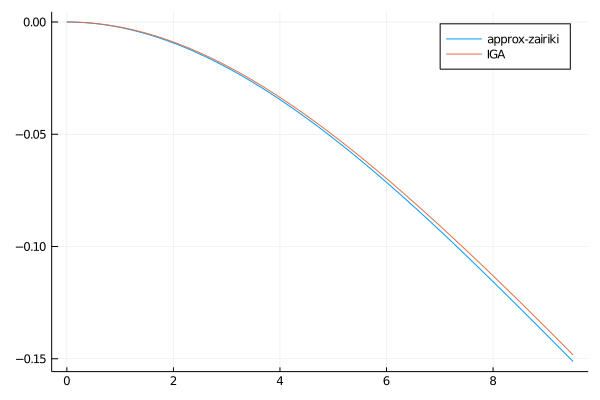

In [15]:
# 材力の解との比較

# 材力の解
W = 10.0
I = 1.0/12.0
L1 = 9.5

Es = μ*(3λ+2μ)/(λ+μ)
ν = λ/(2*(λ+μ))
En = Es/(1-ν^2)

xl = 100
xplot = collect(range(1.0e-10,stop=9.5-1.0e-10,length=xl))
y = zeros(Float64,xl)
for i in 1:xl
    y[i] = W/(En*I)*(xplot[i]^3/6.0-L1*xplot[i]^2/2.0)
end

xplot2 = collect(range(1.0e-10,stop=9.5-1.0e-10,length=div(xl,2)))

# 比較
plot(xplot,y,label="approx-zairiki")
plot!(xplot2,u[2,1:div(t1l,2),div(t2l,2),t3l],label="IGA")